In [ ]:
# Standard Libraries
import random
import os
import pickle
import json

# Numerical Libraries
import numpy as np
import pandas as pd

# Visualization Libraries
import matplotlib.pyplot as plt

# Machine Learning & Statistics
from sklearn.metrics import mean_squared_error

# Jupyter Notebook Imports
import import_ipynb

# PyTorch & Deep Learning Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Custom Modules
from phased_lstm_implementation import PLSTM, Model
import joblib
scaler_y = joblib.load("data/scaler_y.pkl")

# Hyperparameter Tuning
import optuna
from optuna.pruners import HyperbandPruner




In [3]:
#Seed 
SEED = 42

def set_seed():

    # PyTorch Seed
    torch.manual_seed(SEED)

    # NumPy Seed
    np.random.seed(SEED)

    # Python random seed
    random.seed(SEED)
    # Determinismus erzwingen
    torch.backends.cudnn.deterministic = True

    # Keine automatische Optimierung
    torch.backends.cudnn.benchmark = False  

    os.environ["PYTHONHASHSEED"] = str(SEED)
    torch.use_deterministic_algorithms(True)

set_seed()

In [4]:
# Data Import 

# Load X_train
with open("data/X_train.pkl", "rb") as f:
    X_train = pickle.load(f)

# Load y_train
with open("data/y_train.pkl", "rb") as f:
    y_train = pickle.load(f)

# Load X_val
with open("data/X_val.pkl", "rb") as f:
    X_val = pickle.load(f)

# Load y_val
with open("data/y_val.pkl", "rb") as f:
    y_val = pickle.load(f)

# Load X_test
with open("data/X_test.pkl", "rb") as f:
    X_test = pickle.load(f)

# Load y_test
with open("data/y_test.pkl", "rb") as f:
    y_test = pickle.load(f)

# Load df_final_viz
with open("data/df_final_viz.pkl", "rb") as f:
    df_final_viz = pickle.load(f)

In [5]:
# Setting the Number of CPU Threads in PyTorch
num_threads = max(1, os.cpu_count() // 2)
torch.set_num_threads(num_threads)
print(f"PyTorch uses: {torch.get_num_threads()} Threads")

PyTorch uses: 6 Threads


In [6]:
# Convert data into PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Create TensorDataset for train, validation, and test sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

#DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=False, num_workers=6)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=6)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=6)

In [28]:
X_train_tensor.shape

torch.Size([27024, 24, 17])

In [7]:
USE_GPU = False

if USE_GPU and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Model runs on: {device}")

class StackedLSTMModel(nn.Module):
    def __init__(self, input_size, hp):
        super(StackedLSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hp['lstm_units_1'], batch_first=True)
        self.dropout1 = nn.Dropout(hp['dropout_rate_lstm_1'])
        self.lstm2 = nn.LSTM(hp['lstm_units_1'], hp['lstm_units_2'], batch_first=True)
        self.dropout2 = nn.Dropout(hp['dropout_rate_lstm_2'])
        self.fc1 = nn.Linear(hp['lstm_units_2'], hp['dense_units'])
        self.dropout3 = nn.Dropout(hp['dropout_rate_dense'])
        self.fc2 = nn.Linear(hp['dense_units'], 1)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out = self.dropout1(out)
        out, _ = self.lstm2(out)
        out = self.dropout2(out)
        out = out[:, -1, :]
        out = self.fc1(out)
        out = self.dropout3(out)
        out = self.fc2(out)
        return out

Model runs on: cpu


In [8]:
# Objective-function with Hyperband-Pruning for SLSTM
def objective(trial):
    hp = {
        'lstm_units_1': trial.suggest_int('lstm_units_1', 32, 256, step=16),
        'lstm_units_2': trial.suggest_int('lstm_units_2', 32, 256, step=16),
        'dropout_rate_lstm_1': trial.suggest_float('dropout_rate_lstm_1', 0.1, 0.3, step=0.1),
        'dropout_rate_lstm_2': trial.suggest_float('dropout_rate_lstm_2', 0.1, 0.3, step=0.1),
        'dense_units': trial.suggest_int('dense_units', 8, 64, step=8),
        'dropout_rate_dense': trial.suggest_float('dropout_rate_dense', 0.0, 0.4, step=0.1),
        'learning_rate': trial.suggest_categorical('learning_rate', [1e-2, 1e-3, 1e-4])
    }

    set_seed()

    slstm_model = StackedLSTMModel(input_size=X_train.shape[2], hp=hp)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(slstm_model.parameters(), lr=hp['learning_rate'])

    num_epochs = 15
    patience = 5  
    best_val_loss = float('inf')
    early_stopping_counter = 0


    for epoch in range(num_epochs):
        slstm_model.train()
        total_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = slstm_model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)

        # Validation
        slstm_model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                y_pred = slstm_model(X_batch)
                loss = criterion(y_pred, y_batch)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        # Optuna-Pruning Check
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                break

    return best_val_loss

# Study with HyperbandPruner
sampler = optuna.samplers.TPESampler(seed=SEED) 
pruner = optuna.pruners.HyperbandPruner(min_resource=3, max_resource=15, reduction_factor=3)
study = optuna.create_study(direction='minimize', pruner=pruner)
study.optimize(objective, n_trials=10, n_jobs=1)

# Show Best Result
print("Best trial parameters:")
for key, value in study.best_trial.params.items():
    print(f"{key}: {value}")

[I 2025-04-04 15:05:15,951] A new study created in memory with name: no-name-df02286f-c2eb-4633-a726-8b79c022f04c
[I 2025-04-04 15:08:33,585] Trial 0 finished with value: 0.0005685389371355995 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 176, 'dropout_rate_lstm_1': 0.3, 'dropout_rate_lstm_2': 0.1, 'dense_units': 8, 'dropout_rate_dense': 0.2, 'learning_rate': 0.001}. Best is trial 0 with value: 0.0005685389371355995.
[I 2025-04-04 15:09:16,828] Trial 1 pruned. 
[I 2025-04-04 15:11:30,211] Trial 2 finished with value: 0.0006375075271935202 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 32, 'dropout_rate_lstm_1': 0.3, 'dropout_rate_lstm_2': 0.3, 'dense_units': 8, 'dropout_rate_dense': 0.2, 'learning_rate': 0.01}. Best is trial 0 with value: 0.0005685389371355995.
[I 2025-04-04 15:12:40,052] Trial 3 pruned. 
[I 2025-04-04 15:13:41,504] Trial 4 pruned. 
[I 2025-04-04 15:16:53,828] Trial 5 finished with value: 0.0012143552100751548 and parameters: {'lstm_units_1': 144, 'lstm_un

Best trial parameters:
lstm_units_1: 32
lstm_units_2: 176
dropout_rate_lstm_1: 0.3
dropout_rate_lstm_2: 0.1
dense_units: 8
dropout_rate_dense: 0.2
learning_rate: 0.001


In [ ]:
# save best hyperparameters
best_hp = study.best_trial.params
with open("best_hp_all_models/best_hp_slstm.json", "w") as f:
    json.dump(best_hp, f)

In [ ]:
# load best hyperparameters
with open("best_hp_all_models/best_hp_slstm.json", "r") as f:
    best_hp = json.load(f)

Epoch [1/50], Train Loss: 0.0040, Val Loss: 0.0014
Epoch [2/50], Train Loss: 0.0015, Val Loss: 0.0012
Epoch [3/50], Train Loss: 0.0016, Val Loss: 0.0017
Epoch [4/50], Train Loss: 0.0017, Val Loss: 0.0014
Epoch [5/50], Train Loss: 0.0016, Val Loss: 0.0006
Epoch [6/50], Train Loss: 0.0017, Val Loss: 0.0016
Epoch [7/50], Train Loss: 0.0015, Val Loss: 0.0019
Epoch [8/50], Train Loss: 0.0016, Val Loss: 0.0009
Epoch [9/50], Train Loss: 0.0068, Val Loss: 0.0123
Epoch [10/50], Train Loss: 0.0238, Val Loss: 0.0155
Epoch [11/50], Train Loss: 0.0157, Val Loss: 0.0071
Epoch [12/50], Train Loss: 0.0037, Val Loss: 0.0019
Epoch [13/50], Train Loss: 0.0022, Val Loss: 0.0018
Epoch [14/50], Train Loss: 0.0018, Val Loss: 0.0016
Epoch [15/50], Train Loss: 0.0016, Val Loss: 0.0007
Early stopping nach 15 Epochen.


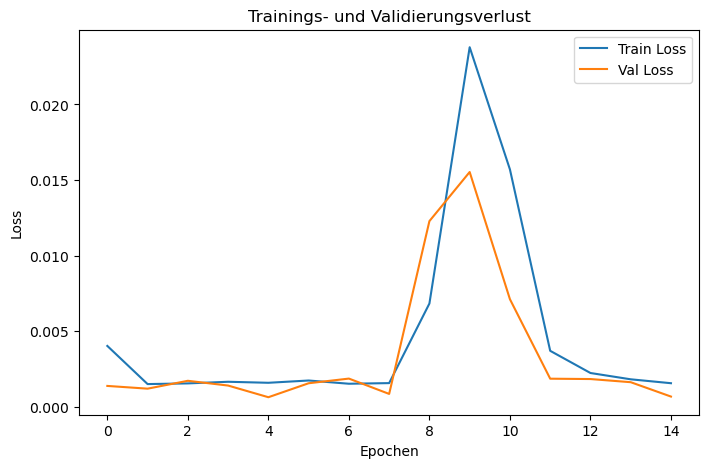

In [ ]:
# Bestes Modell mit den gefundenen Hyperparametern trainieren
set_seed()

final_model = StackedLSTMModel(input_size=X_train.shape[2], hp=best_hp)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(final_model.parameters(), lr=best_hp['learning_rate'])

num_epochs = 50
patience = 10  # Stop, wenn val_loss sich x Epochen lang nicht verbessert
best_val_loss = float('inf')
early_stopping_counter = 0
train_loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    final_model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = final_model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_loss_history.append(train_loss)

    # Validation Loss berechnen
    final_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            y_pred = final_model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_loss_history.append(val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Early Stopping Check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0  # Reset Counter
        torch.save(final_model.state_dict(), "saved_models/slstm_model_final.pth") #save only best weights
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print(f"Early stopping nach {epoch+1} Epochen.")
            break


# **Trainingshistorie plotten**
plt.figure(figsize=(8, 5))
plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Val Loss")
plt.xlabel("Epochen")
plt.ylabel("Loss")
plt.legend()
plt.title("Trainings- und Validierungsverlust")
plt.show()

In [ ]:
# load trained model  
slstm_final = StackedLSTMModel(input_size=X_train.shape[2], hp=best_hp)
slstm_final.load_state_dict(torch.load("saved_models/slstm_model_final.pth"))
slstm_final.eval()

StackedLSTMModel(
  (lstm1): LSTM(17, 224, batch_first=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (lstm2): LSTM(224, 224, batch_first=True)
  (dropout2): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=224, out_features=64, bias=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
from sklearn.metrics import mean_squared_error

set_seed()

# Make predictions
def get_predictions_in_batches(model, X_tensor, batch_size=128):
    model.eval()
    preds = []
    with torch.no_grad():
        for i in range(0, len(X_tensor), batch_size):
            batch = X_tensor[i:i+batch_size]
            preds.append(model(batch).numpy()) 
    return np.vstack(preds)

train_predictions = get_predictions_in_batches(slstm_final, X_train_tensor)
validation_predictions = get_predictions_in_batches(slstm_final, X_val_tensor)
test_predictions = get_predictions_in_batches(slstm_final, X_test_tensor)

# Inverse transform scaled predictions and scaled target
train_predictions_actual = scaler_y.inverse_transform(train_predictions)
validation_predictions_actual = scaler_y.inverse_transform(validation_predictions)
test_predictions_actual = scaler_y.inverse_transform(test_predictions)

y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1))
y_val_actual = scaler_y.inverse_transform(y_val.reshape(-1, 1))
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Calculate loss on original scale
mse_train = mean_squared_error(y_train_actual, train_predictions_actual)
rmse_train = np.sqrt(mse_train)

mse_val = mean_squared_error(y_val_actual, validation_predictions_actual)
rmse_val = np.sqrt(mse_val)

mse_test = mean_squared_error(y_test_actual, test_predictions_actual)
rmse_test = np.sqrt(mse_test)

print(f"Original Train MSE: {mse_train:.4f}, Original Train RMSE: {rmse_train:.4f}")
print(f"Original Validation MSE: {mse_val:.4f}, Original Validation RMSE: {rmse_val:.4f}")
print(f"Original Test MSE: {mse_test:.4f}, Original Test RMSE: {rmse_test:.4f}")

# Calculate loss on scaled test data
mse_test_scaled = mean_squared_error(y_test_tensor, test_predictions)
rmse_test_scaled = np.sqrt(mse_test_scaled)
print(f"Scaled Test MSE: {mse_test_scaled:.4f}, Scaled Test RMSE: {rmse_test_scaled:.4f}")

# Plot of the forecast
plt.figure(figsize=(10, 6))

# Plot of actual values
seq_length = 24 ################################# hier änder wenn sich sequenz ändert!!!!!!!!!!!!!!!!!!!!!!!!
plt.plot(df_final_viz.index[seq_length:], df_final_viz['price actual'][seq_length:], label='Actual', color='blue')

# Training predictions
train_start = seq_length
train_end = train_start + len(train_predictions_actual)
plt.plot(df_final_viz.index[train_start:train_end], train_predictions_actual, label='Train Predictions', color='green', alpha=0.8)

# Validation predictions 
val_start = train_end + seq_length
val_end = val_start + len(validation_predictions_actual)
plt.plot(df_final_viz.index[val_start:val_end], validation_predictions_actual, label='Validation Predictions', color='red', alpha=0.8)

# Test predictions 
test_start = val_end + seq_length
test_end = test_start + len(test_predictions_actual)
plt.plot(df_final_viz.index[test_start:test_end], test_predictions_actual, label='Test Predictions', color='orange', alpha=0.8)

plt.title('Electricity Price Time Series Forecasting (SLSTM)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
for name, param in slstm_final.named_parameters():
    print(f"{name}: {param.shape}")
    
total_params = sum(p.numel() for p in slstm_final.parameters())
print(f"Total number of model paramters Stacked SLSTM: {total_params:,}")

lstm1.weight_ih_l0: torch.Size([960, 17])
lstm1.weight_hh_l0: torch.Size([960, 240])
lstm1.bias_ih_l0: torch.Size([960])
lstm1.bias_hh_l0: torch.Size([960])
lstm2.weight_ih_l0: torch.Size([128, 240])
lstm2.weight_hh_l0: torch.Size([128, 32])
lstm2.bias_ih_l0: torch.Size([128])
lstm2.bias_hh_l0: torch.Size([128])
fc1.weight: torch.Size([8, 32])
fc1.bias: torch.Size([8])
fc2.weight: torch.Size([1, 8])
fc2.bias: torch.Size([1])
Total number of model paramters Stacked LSTM: 283,985
